In [1]:
# --- Imports standard libraries ---
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import importlib
import torch.nn.functional as F

# --- Imports project modules ---
import data
import tools
import plot
importlib.reload(data)
importlib.reload(tools)
importlib.reload(plot)

from tools import *      
from data import *
from plot import *

# --- Matplotlib settings ---
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 4)
plt.rcParams['axes.grid'] = True


In [2]:
df = pd.read_pickle('../data_gait/data/merged_signals.pkl')

In [3]:
df.head()

,patients,TAX,TAY,TOX,rightGaitEvents,leftGaitEvents
0,CIPN_1,"[9.695209597816364, 9.695554473432, 9.69742727...","[0.2011174900482341, 0.1705340478275278, 0.143...","[-2.39540584325809, -2.396080302690895, -2.397...","[[617, 659], [765, 808], [899, 958], [1025, 10...","[[694, 738], [832, 874], [961, 1001], [1089, 1..."
1,CIPN_10,"[9.047783180042517, 9.040844865804663, 9.03603...","[0.5415099869775954, 0.5473924990487681, 0.551...","[-1.0118554899409, -1.009616189981572, -1.0081...","[[299, 339], [413, 454], [525, 563], [635, 673...","[[235, 274], [356, 397], [469, 510], [579, 618..."
2,CIPN_11,"[9.523542742385107, 9.68686407827814, 9.800213...","[0.5377292960250141, 0.2131335689962984, -0.02...","[-0.6602874161533667, -0.6588068965605068, -0....","[[600, 645], [725, 766], [840, 880], [955, 995...","[[536, 578], [667, 708], [783, 825], [897, 939..."
3,CIPN_12,"[9.794258474526517, 9.800721205492453, 9.80410...","[0.4032278590735985, 0.4505801661823457, 0.485...","[1.1281105147435966, 1.135654800104748, 1.1422...","[[809, 851], [983, 1045], [1159, 1215], [1322,...","[[904, 954], [1079, 1135], [1243, 1301], [1411..."
4,CIPN_13,"[9.432345003825017, 9.421636881881676, 9.41640...","[-0.4002949350985451, -0.377307474902458, -0.3...","[0.416711919891381, 0.4201156607562876, 0.4256...","[[384, 432], [532, 576], [657, 700], [781, 827...","[[463, 509], [592, 638], [716, 765], [844, 893..."


In [4]:
def build_X(df, signal_names, start=500, end=1300):
    all_signals = []
    min_len = None

    for i, row in df.iterrows():
        # FIX START ---------------------------------------------------------
        # 1. Extract the actual lists/arrays from the cells
        # This creates a list of arrays: [ [val, val...], [val, val...] ]
        raw_signals = [np.array(row[col], dtype=np.float32) for col in signal_names]
        
        # 2. Stack them so shape becomes (Time_Steps, Number_of_Features)
        # np.column_stack treats 1D arrays as columns
        sig = np.column_stack(raw_signals) 
        # FIX END -----------------------------------------------------------

        if min_len is None or len(sig) < min_len:
            min_len = len(sig)
        all_signals.append(sig)

    # Truncate all signals to the same length (Time dimension)
    truncated = [sig[:min_len] for sig in all_signals]
    
    # Verify the stack produces a numeric array, not an object array
    np_data = np.stack(truncated)
    
    # stack into a tensor of shape S x N x P (Subjects x Time x Channels)
    X = torch.tensor(np_data, dtype=torch.float32)

    # Handle slicing
    X = X[:, start:end, :]
    
    # Normalize
    X = X - X.mean(dim=1, keepdim=True)
    X = X / (X.std(dim=1, keepdim=True) + 1e-8)

    return X


In [13]:
healthy_df = pd.read_pickle('../data_gait/data/healthy_signals.pkl')

In [35]:
def init_from_df(df, signal_names, K, L,M = 30):
    # Convert DataFrame to tensor
    X = build_X(df, signal_names,start=0,end=None)

    assert K==2, 'This initialization assumes K=2 (left and right gait cycles).'

    S,N,P = X.shape
    T_Z = N - L + 1

    Phi = torch.zeros(K, L, P)

    #Initialize Z first
    Z = torch.zeros(S, K, T_Z)
    for s in range(S):
        # retrieve gait events
        left_cycles = df.iloc[s]['leftGaitEvents']
        right_cycles = df.iloc[s]['rightGaitEvents']

        # extract start times
        left_starts = [event[0] for event in left_cycles]
        right_starts = [event[0] for event in right_cycles]


        # set activations in Z
        for i in left_starts: 
            if i < T_Z: Z[s, 0, i] = 1.0
        for i in right_starts: 
            if i < T_Z and K > 1: Z[s, 1, i] = 1.0

    # We iterate over the atoms (Left=0, Right=1)
    for k in range(K):
        # We iterate over every sensor channel
        for p in range(P):
            collected_crops = []
            
            # Loop over subjects to find their FIRST step
            for s in range(S):
                # Find all indices where this subject has a step for atom k
                # (nonzero returns a tuple, we take the index tensor)
                step_indices = torch.nonzero(Z[s, k, :], as_tuple=False).squeeze()
                
                # If the subject has at least one step
                if step_indices.numel() > 0:
                    # Handle case where nonzero returns a scalar or vector
                    if step_indices.ndim == 0:
                        first_idx = step_indices.item()
                    else:
                        first_idx = step_indices[0].item()
                    
                    # Extract the pattern from X (crop length L)
                    # We strictly check bounds to avoid crashing if the step is at the very end
                    if first_idx + L <= N:
                        crop = X[s, first_idx : first_idx + L, p]
                        collected_crops.append(crop)
            
            # Compute the Mean Pattern across all subjects
            if len(collected_crops) > 0:
                # Stack crops to shape (Num_Subjects, L) and take mean over dim 0
                avg_pattern = torch.stack(collected_crops).mean(dim=0)
                
                # Center the atom (zero-mean)
                avg_pattern = avg_pattern - avg_pattern.mean()
                
                # Assign to Phi
                Phi[k, :, p] = avg_pattern
            else:
                # Fallback if NO steps were found for this atom/channel (rare)
                print(f"Warning: No events found for Atom {k}, Channel {p}. initializing with noise.")
                Phi[k, :, p] = torch.randn(L, dtype=dtype, device=device) * 0.01




    A = torch.zeros(S, K, M)

    return X, Phi, Z, A

In [36]:
X,Phi,Z,A = init_from_df(healthy_df, ['TAX', 'TAY'], K=2, L=50)

In [37]:
X.shape

torch.Size([73, 1639, 2])

In [38]:
Zf, Phif, Af=CDL(X,nb_atoms=2,D=4,W=15,lambda_=0.01,n_iters=30,signal_names=['TAX', 'TAY'],init = [Phi,Z,A])

--- Displaying Atoms (Phi) ---


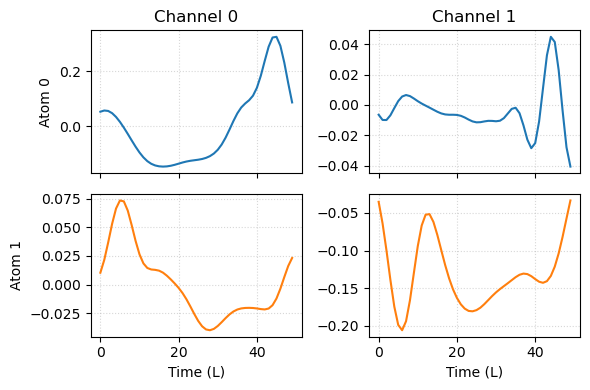


--- Reconstruction and MSE per Subject ---


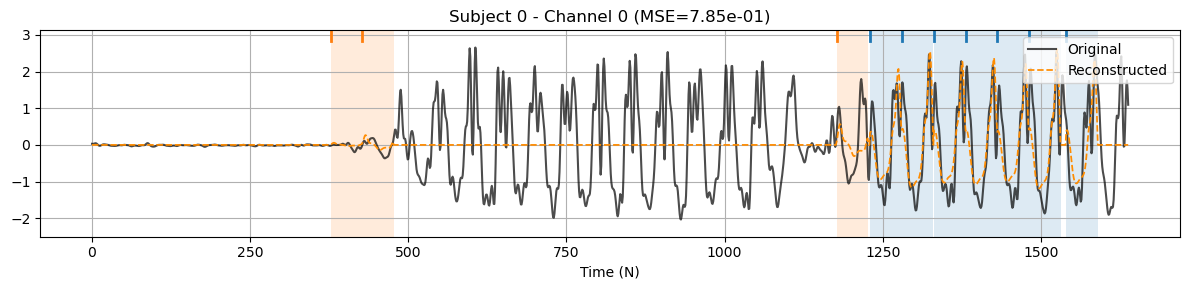

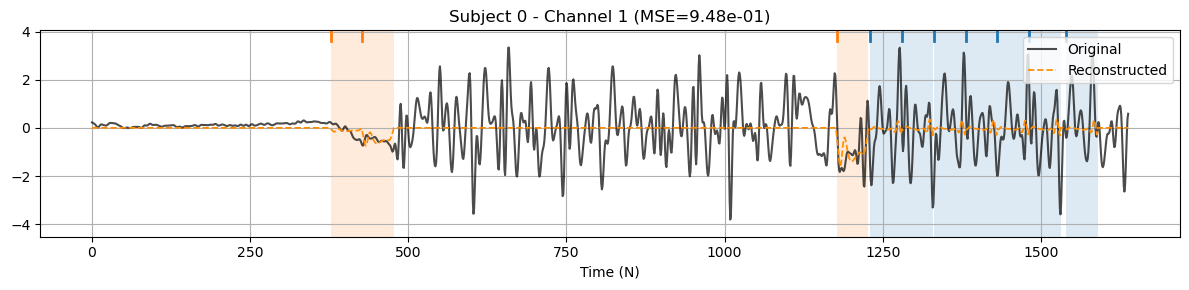

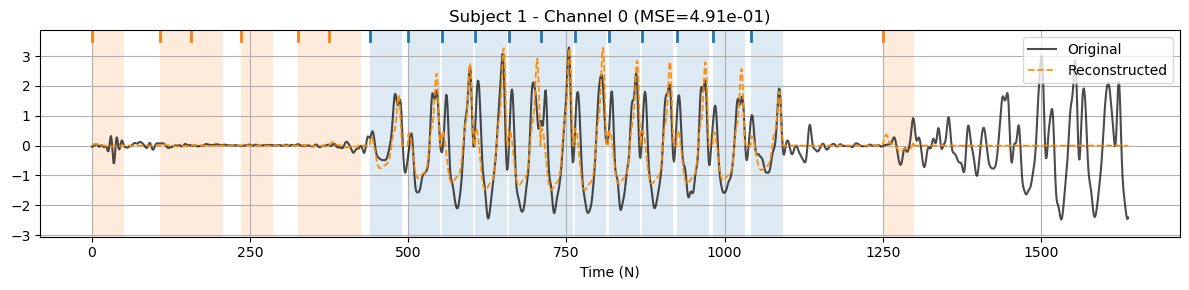

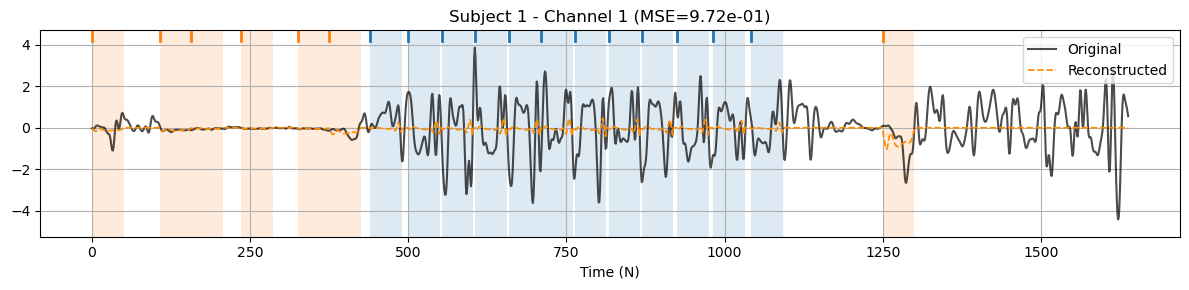

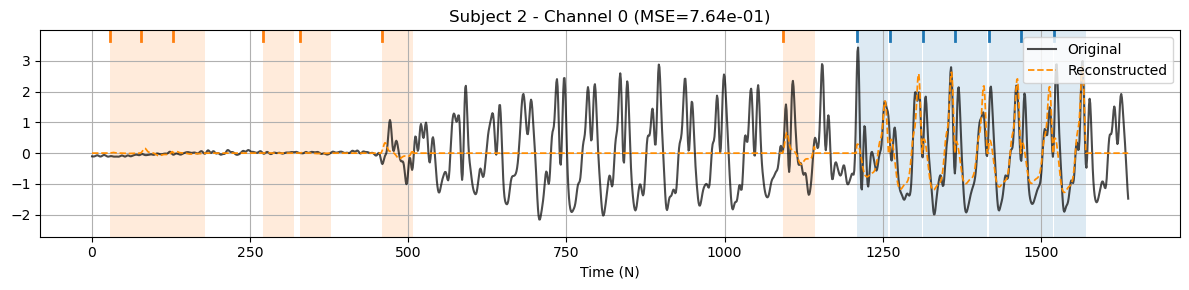

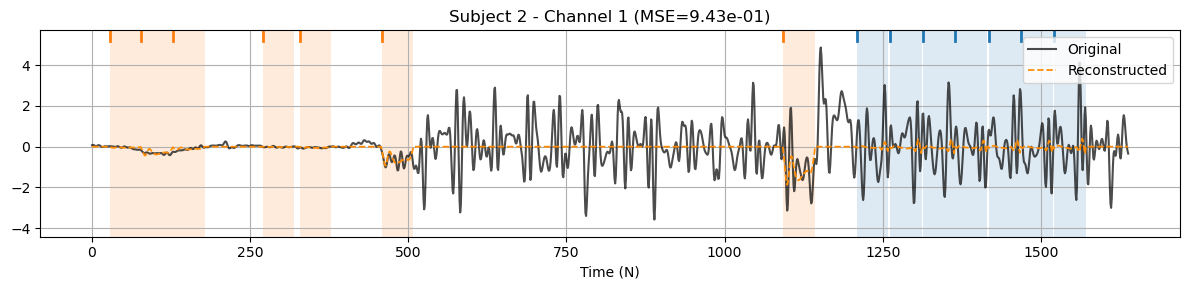


--- Displaying Activations (Z) ---


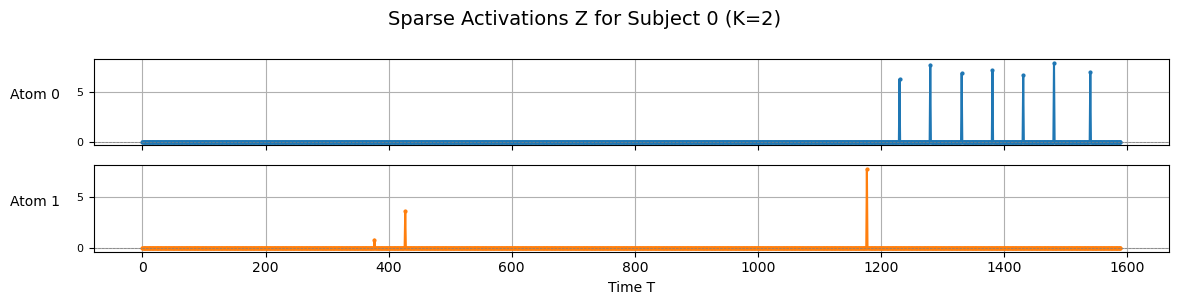

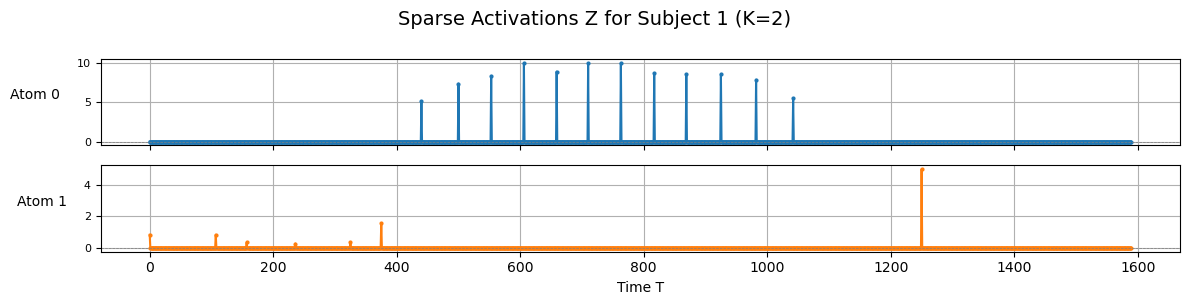

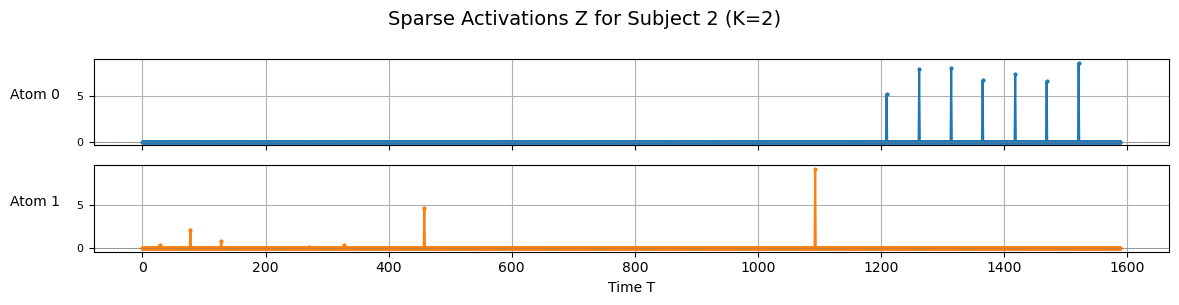


--- Global Statistics ---
MSE Mean: 6.841305e-01 | Std: 1.126939e-01
MSE Min : 4.873596e-01 | Max: 9.822190e-01
Sparsity Rate (>1e-9): 0.6001%
Avg active coefficients per subject: 19.08


In [39]:
full_plot_analysis(X,Zf,Phif,n_display=3)

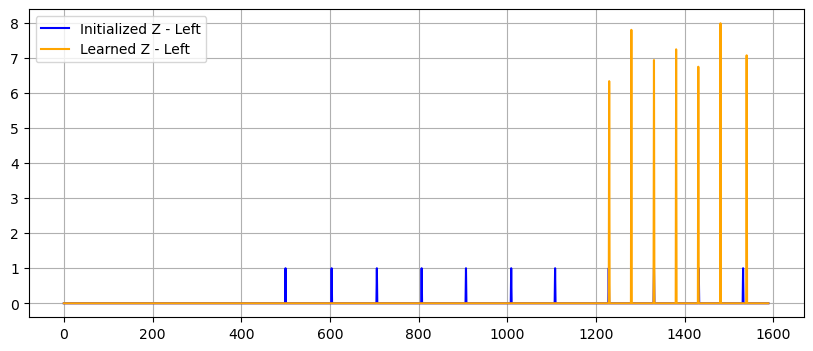

In [40]:
plt.plot(Z[0, 0, :], label='Initialized Z - Left',color='blue')
plt.plot(Zf[0, 0, :].detach().numpy(), label='Learned Z - Left',color='orange')
plt.legend()


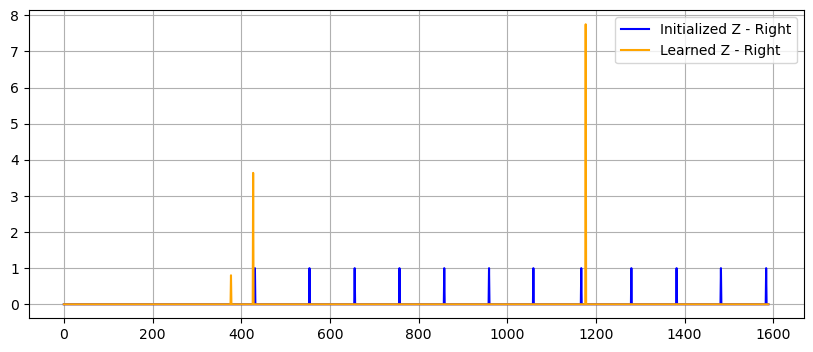

In [41]:
plt.plot(Z[0, 1, :], label='Initialized Z - Right',color='blue')
plt.plot(Zf[0, 1, :].detach().numpy(), label='Learned Z - Right',color='orange')
plt.legend()